In [4]:
from IPython.display import Video
from pathlib import Path
import seaborn as sns
sns.set()

import pandas as pd
import numpy as np
import torch
import gym

from lagom import EpisodeRunner
from lagom.envs import TimeStepEnv
from lagom.envs import NormalizeObservation
from lagom.utils import pickle_load
from lagom.utils import yaml_load
from lagom.vis import set_ticker
from lagom.vis import read_xy
from lagom.experiment import Config


def get_configs(log_folder):
    data = pickle_load(Path(log_folder) / 'configs.pkl')
    configs = pd.DataFrame(data, columns=data[0].keys())
    return configs


def make_video(make_env, agent_class, id_folder, seed, num_iter):
    id_folder = Path(id_folder)
    seed_folder = id_folder / str(seed)
    anim_folder = seed_folder / 'anim' 
    if not anim_folder.exists():
        anim_folder.mkdir(parents=True)

    config = Config(yaml_load(id_folder / 'config.yml'))
    config.seed = seed
    config.device = torch.device('cpu')
    
    env = make_env(config, 'eval')
    assert isinstance(env, TimeStepEnv)
    env = env.env  # strip out TimeStepEnv for some wrappers
    env = gym.wrappers.Monitor(env, anim_folder, force=True)
    if 'env.normalize_obs' in config and config['env.normalize_obs']:
        moments = np.load(seed_folder / f'obs_moments_{num_iter}.pth', allow_pickle=True)
        env = NormalizeObservation(env, clip=5., constant_moments=moments)
    env = TimeStepEnv(env)
    agent = agent_class(config, env)
    agent.load(seed_folder / f'agent_{num_iter}.pth')
    agent.eval()
    runner = EpisodeRunner()
    with torch.no_grad():
        [traj] = runner(agent, env, 1, mode='eval')
    env.close()
    print(f'Evaluation:\n\tHorizon: {traj.T}, Return: {sum(traj.rewards)}')
    
    # display the video
    return Video(list(anim_folder.glob('openaigym*000000.mp4'))[0])

## Model-free RL
- [VPG](#VPG)
- [PPO](#PPO)
- [DDPG](#DDPG)
- [TD3](#TD3)
- [SAC](#SAC)

## ES
- [CEM](#CEM)
- [CMA-ES](#CMA-ES)
- [OpenAI-ES](#OpenAI-ES)

[Benchmarking](#Benchmarking)

## VPG

In [5]:
log_folder = 'vpg/logs/default/'
get_configs(log_folder)

,ID,log.freq,checkpoint.inference.num,env.id,env.normalize_obs,env.normalize_reward,use_lstm,rnn.size,nn.sizes,agent.lr,...,agent.gamma,agent.gae_lambda,agent.standardize_adv,agent.max_grad_norm,agent.entropy_coef,agent.value_coef,env.clip_action,agent.std0,train.timestep,train.timestep_per_iter
0,0,10,3,HalfCheetah-v3,True,True,False,128,"[64, 64]",0.001,...,0.99,0.97,True,0.5,0.01,0.5,True,0.6,1000000,1000


In [8]:
get_x = lambda log: log['accumulated_trained_timesteps'][0]
get_y = lambda log: log['online_return'][0].mean
file_name = 'train_logs.pkl'
data = read_xy(log_folder, file_name, get_x, get_y, smooth_out=True)
data.head()

,x,y,ID,log.freq,checkpoint.inference.num,env.id,env.normalize_obs,env.normalize_reward,use_lstm,rnn.size,...,agent.gamma,agent.gae_lambda,agent.standardize_adv,agent.max_grad_norm,agent.entropy_coef,agent.value_coef,env.clip_action,agent.std0,train.timestep,train.timestep_per_iter
0,1000,-263.454311,0.0,10.0,3.0,HalfCheetah-v3,True,True,False,128.0,...,0.99,0.97,True,0.5,0.01,0.5,True,0.6,1000000.0,1000.0
1,2000,-263.406163,0.0,10.0,3.0,HalfCheetah-v3,True,True,False,128.0,...,0.99,0.97,True,0.5,0.01,0.5,True,0.6,1000000.0,1000.0
2,3000,-263.019241,0.0,10.0,3.0,HalfCheetah-v3,True,True,False,128.0,...,0.99,0.97,True,0.5,0.01,0.5,True,0.6,1000000.0,1000.0
3,4000,-262.307468,0.0,10.0,3.0,HalfCheetah-v3,True,True,False,128.0,...,0.99,0.97,True,0.5,0.01,0.5,True,0.6,1000000.0,1000.0
4,5000,-261.284766,0.0,10.0,3.0,HalfCheetah-v3,True,True,False,128.0,...,0.99,0.97,True,0.5,0.01,0.5,True,0.6,1000000.0,1000.0


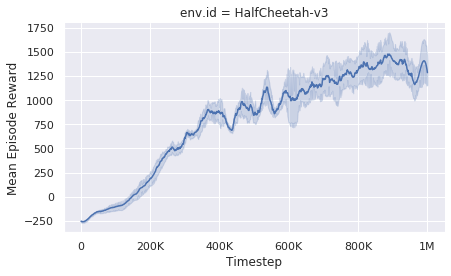

In [9]:
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue=None,
                #hue='use_lstm',
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Timestep')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

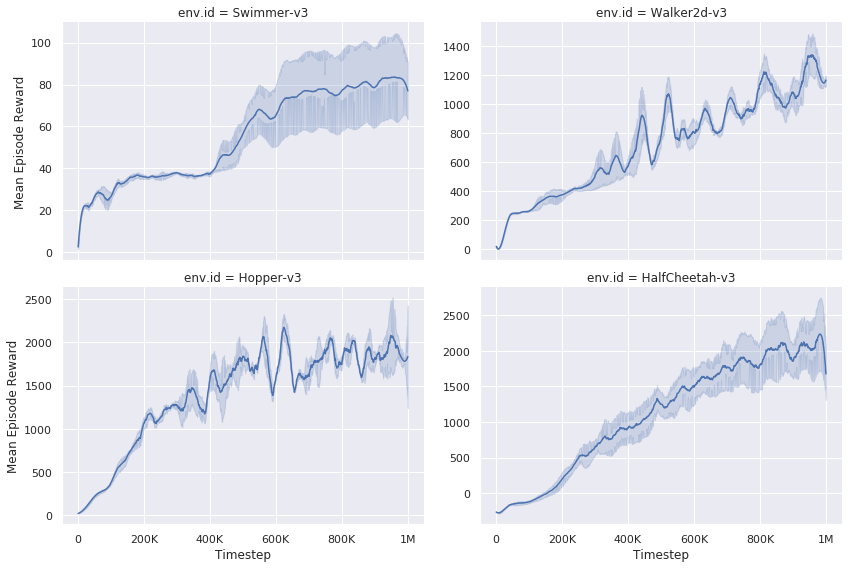

In [7]:
from vpg.agent import Agent
from vpg.experiment import make_env
make_video(make_env, Agent, 'vpg/logs/default/0', seed=1084389005, num_iter=1001)

Evaluation:
	Horizon: 1000, Return: 1884.8379453950108


## PPO

In [6]:
log_folder = 'ppo/logs/default/'
get_configs(log_folder)

,ID,log.freq,checkpoint.num,env.normalize_obs,env.normalize_reward,nn.sizes,agent.policy_lr,agent.use_lr_scheduler,agent.value_lr,agent.gamma,...,agent.standardize_adv,agent.max_grad_norm,agent.clip_range,env.clip_action,agent.std0,train.timestep,train.timestep_per_iter,train.batch_size,train.num_epochs,env.id
0,0,10,3,True,True,"[64, 64]",0.0003,True,0.001,0.99,...,True,0.5,0.2,True,0.6,1000000,2048,64,10,HalfCheetah-v3
1,1,10,3,True,True,"[64, 64]",0.0003,True,0.001,0.99,...,True,0.5,0.2,True,0.6,1000000,2048,64,10,Hopper-v3
2,2,10,3,True,True,"[64, 64]",0.0003,True,0.001,0.99,...,True,0.5,0.2,True,0.6,1000000,2048,64,10,Walker2d-v3
3,3,10,3,True,True,"[64, 64]",0.0003,True,0.001,0.99,...,True,0.5,0.2,True,0.6,1000000,2048,64,10,Swimmer-v3


In [7]:
get_x = lambda log: log['accumulated_trained_timesteps'][0]
get_y = lambda log: log['online_return'][0].mean
file_name = 'train_logs.pkl'
data = read_xy(log_folder, file_name, get_x, get_y, smooth_out=True)
data.head()

,x,y,ID,log.freq,checkpoint.num,env.normalize_obs,env.normalize_reward,nn.sizes,agent.policy_lr,agent.use_lr_scheduler,...,agent.standardize_adv,agent.max_grad_norm,agent.clip_range,env.clip_action,agent.std0,train.timestep,train.timestep_per_iter,train.batch_size,train.num_epochs,env.id
0,2048,7.209084,3.0,10.0,3.0,True,True,"(64, 64)",0.0003,True,...,True,0.5,0.2,True,0.6,1000000.0,2048.0,64.0,10.0,Swimmer-v3
1,4096,9.844616,3.0,10.0,3.0,True,True,"(64, 64)",0.0003,True,...,True,0.5,0.2,True,0.6,1000000.0,2048.0,64.0,10.0,Swimmer-v3
2,6144,12.313595,3.0,10.0,3.0,True,True,"(64, 64)",0.0003,True,...,True,0.5,0.2,True,0.6,1000000.0,2048.0,64.0,10.0,Swimmer-v3
3,8192,14.621439,3.0,10.0,3.0,True,True,"(64, 64)",0.0003,True,...,True,0.5,0.2,True,0.6,1000000.0,2048.0,64.0,10.0,Swimmer-v3
4,10240,16.773564,3.0,10.0,3.0,True,True,"(64, 64)",0.0003,True,...,True,0.5,0.2,True,0.6,1000000.0,2048.0,64.0,10.0,Swimmer-v3


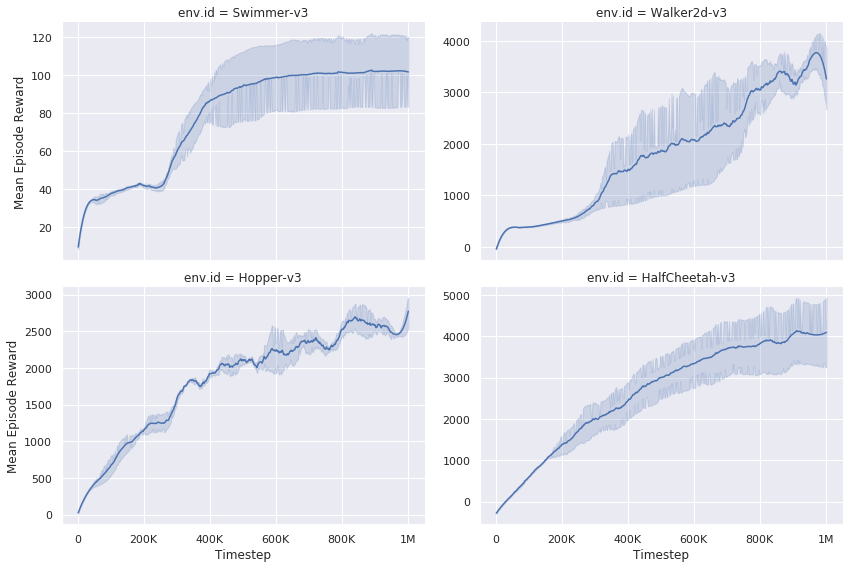

In [8]:
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue=None,
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Timestep')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [11]:
from ppo.agent import Agent
from ppo.experiment import make_env
ID = 2
make_video(f'{log_folder}/{ID}', make_env, Agent, seed=1500925526, num_iter=489)

Evaluation:
	Horizon: 704, Return: 3395.2677133173406


## DDPG

In [13]:
log_folder = 'ddpg/logs/default/'
get_configs(log_folder)

FileNotFoundError: [Errno 2] No such file or directory: 'ddpg/logs/default/configs.pkl'

In [26]:
get_x = lambda log: log['accumulated_trained_timesteps'][0]
get_y = lambda log: log['online_return'][0].mean
file_name = 'eval_logs.pkl'
data = read_xy(log_folder, file_name, get_x, get_y, smooth_out=True)
data.head()

,x,y,ID,log.freq,checkpoint.num,agent.gamma,agent.polyak,agent.actor.lr,agent.actor.use_lr_scheduler,agent.critic.lr,agent.critic.use_lr_scheduler,agent.action_noise,agent.max_grad_norm,replay.capacity,replay.init_size,replay.batch_size,train.timestep,eval.num,env.id
0,1000,34.503577,3.0,10.0,3.0,0.99,0.995,0.001,False,0.001,False,0.1,999999.0,1000000.0,10000.0,100.0,1000000.0,200.0,Swimmer-v3
1,6000,32.816351,3.0,10.0,3.0,0.99,0.995,0.001,False,0.001,False,0.1,999999.0,1000000.0,10000.0,100.0,1000000.0,200.0,Swimmer-v3
2,11000,31.287200,3.0,10.0,3.0,0.99,0.995,0.001,False,0.001,False,0.1,999999.0,1000000.0,10000.0,100.0,1000000.0,200.0,Swimmer-v3
3,16000,29.910984,3.0,10.0,3.0,0.99,0.995,0.001,False,0.001,False,0.1,999999.0,1000000.0,10000.0,100.0,1000000.0,200.0,Swimmer-v3
4,21000,28.682562,3.0,10.0,3.0,0.99,0.995,0.001,False,0.001,False,0.1,999999.0,1000000.0,10000.0,100.0,1000000.0,200.0,Swimmer-v3


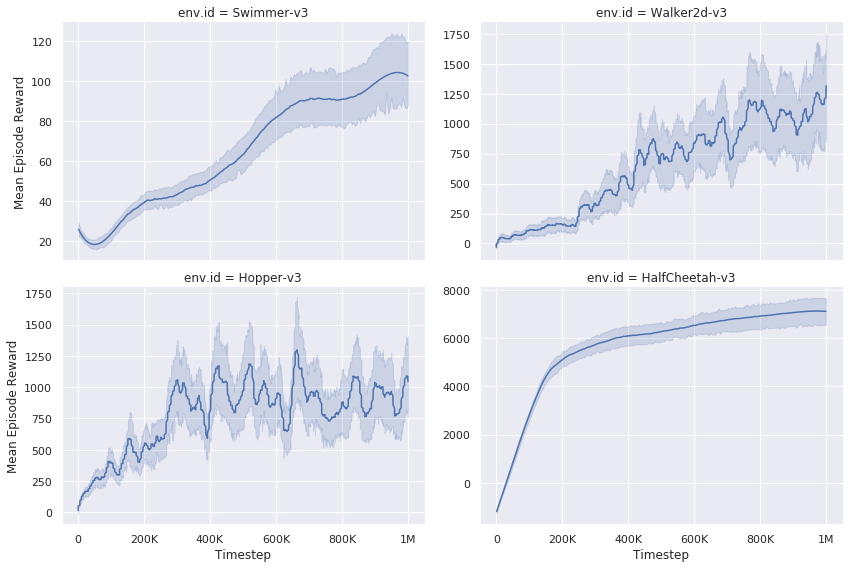

In [22]:
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue=None,
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Timestep')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

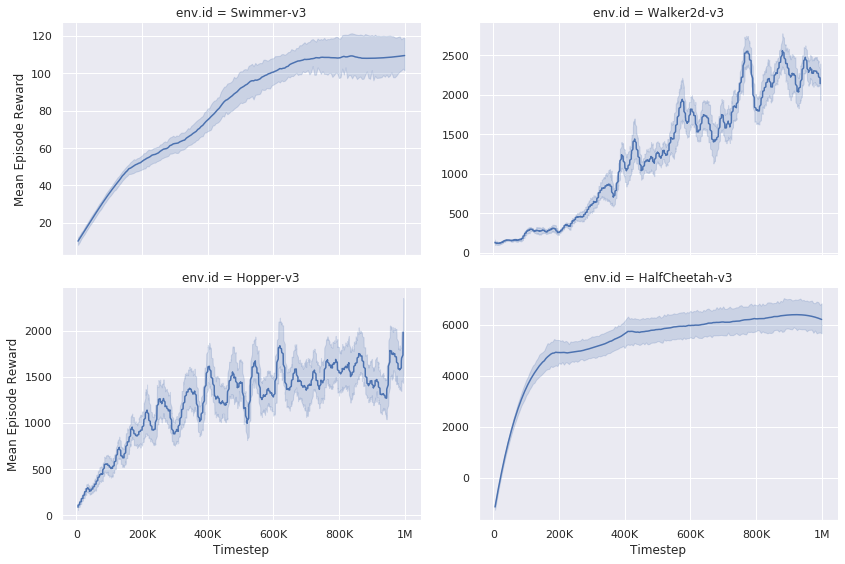

In [31]:
from ddpg.agent import Agent
from ddpg.experiment import make_env
ID = 3
make_video(f'{log_folder}/{ID}', make_env, Agent, seed=4153361530, num_iter=1000)

Evaluation:
	Horizon: 1000, Return: 109.85124658072236


## TD3

In [11]:
log_folder = 'td3/logs/default/'
get_configs(log_folder)

,ID,log.freq,checkpoint.num,agent.gamma,agent.polyak,agent.actor.lr,agent.actor.use_lr_scheduler,agent.critic.lr,agent.critic.use_lr_scheduler,agent.action_noise,...,agent.target_noise_clip,agent.policy_delay,agent.max_grad_norm,replay.capacity,replay.init_size,replay.batch_size,train.timestep,eval.freq,eval.num_episode,env.id
0,0,1000,3,0.99,0.995,0.001,False,0.001,False,0.1,...,0.5,2,999999,1000000,10000,100,1000000,5000,10,HalfCheetah-v3
1,1,1000,3,0.99,0.995,0.001,False,0.001,False,0.1,...,0.5,2,999999,1000000,1000,100,1000000,5000,10,Hopper-v3
2,2,1000,3,0.99,0.995,0.001,False,0.001,False,0.1,...,0.5,2,999999,1000000,1000,100,1000000,5000,10,Walker2d-v3
3,3,1000,3,0.99,0.995,0.001,False,0.001,False,0.1,...,0.5,2,999999,1000000,10000,100,1000000,5000,10,Swimmer-v3


In [12]:
get_x = lambda log: log['accumulated_trained_timesteps'][0]
get_y = lambda log: log['online_return'][0].mean
file_name = 'eval_logs.pkl'
data = read_xy(log_folder, file_name, get_x, get_y, smooth_out=True)
data.head()

,x,y,ID,log.freq,checkpoint.num,agent.gamma,agent.polyak,agent.actor.lr,agent.actor.use_lr_scheduler,agent.critic.lr,...,agent.target_noise_clip,agent.policy_delay,agent.max_grad_norm,replay.capacity,replay.init_size,replay.batch_size,train.timestep,eval.freq,eval.num_episode,env.id
0,5000,22.958380,3.0,1000.0,3.0,0.99,0.995,0.001,False,0.001,...,0.5,2.0,999999.0,1000000.0,10000.0,100.0,1000000.0,5000.0,10.0,Swimmer-v3
1,10000,24.694175,3.0,1000.0,3.0,0.99,0.995,0.001,False,0.001,...,0.5,2.0,999999.0,1000000.0,10000.0,100.0,1000000.0,5000.0,10.0,Swimmer-v3
2,15000,26.327158,3.0,1000.0,3.0,0.99,0.995,0.001,False,0.001,...,0.5,2.0,999999.0,1000000.0,10000.0,100.0,1000000.0,5000.0,10.0,Swimmer-v3
3,20000,27.860485,3.0,1000.0,3.0,0.99,0.995,0.001,False,0.001,...,0.5,2.0,999999.0,1000000.0,10000.0,100.0,1000000.0,5000.0,10.0,Swimmer-v3
4,25000,29.297316,3.0,1000.0,3.0,0.99,0.995,0.001,False,0.001,...,0.5,2.0,999999.0,1000000.0,10000.0,100.0,1000000.0,5000.0,10.0,Swimmer-v3


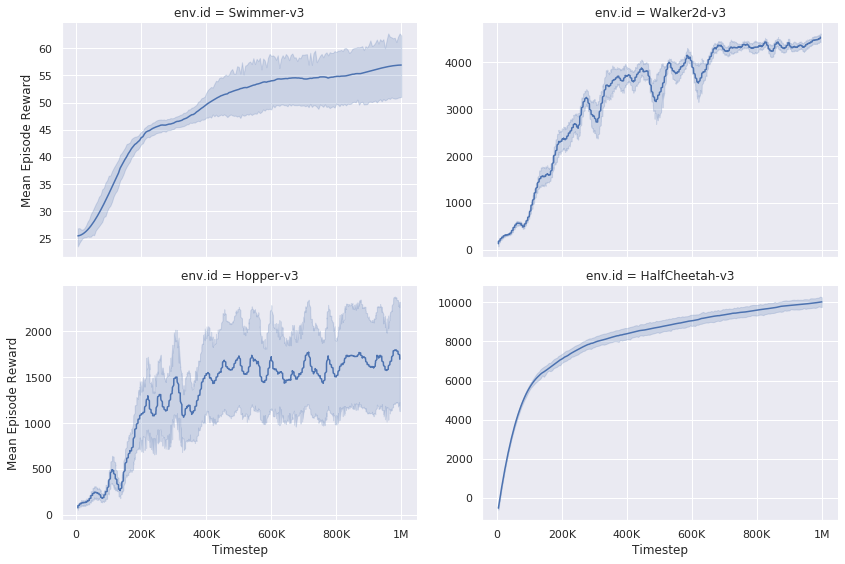

In [13]:
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue=None,
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Timestep')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [14]:
from td3.agent import Agent
from td3.experiment import make_env
ID = 2
make_video(f'{log_folder}/{ID}', make_env, Agent, seed=849059707, num_iter=1688)

Evaluation:
	Horizon: 1000, Return: 4343.720885515517


## SAC

In [14]:
log_folder = 'sac/logs/default/'
get_configs(log_folder)

,ID,log.freq,checkpoint.num,agent.gamma,agent.polyak,agent.actor.lr,agent.actor.use_lr_scheduler,agent.critic.lr,agent.critic.use_lr_scheduler,agent.initial_temperature,agent.max_grad_norm,replay.capacity,replay.init_trial,replay.batch_size,train.timestep,eval.num,env.id
0,0,10,3,0.99,0.995,0.0003,False,0.0003,False,1.0,999999,1000000,10,256,1000000,200,HalfCheetah-v3
1,1,10,3,0.99,0.995,0.0003,False,0.0003,False,1.0,999999,1000000,10,256,1000000,200,Hopper-v3
2,2,10,3,0.99,0.995,0.0003,False,0.0003,False,1.0,999999,1000000,10,256,1000000,200,Walker2d-v3
3,3,10,3,0.99,0.995,0.0003,False,0.0003,False,1.0,999999,1000000,10,256,1000000,200,Swimmer-v3


In [15]:
get_x = lambda log: log['accumulated_trained_timesteps'][0]
get_y = lambda log: log['online_return'][0].mean
file_name = 'eval_logs.pkl'
data = read_xy(log_folder, file_name, get_x, get_y, smooth_out=True)
data.head()

,x,y,ID,log.freq,checkpoint.num,agent.gamma,agent.polyak,agent.actor.lr,agent.actor.use_lr_scheduler,agent.critic.lr,agent.critic.use_lr_scheduler,agent.initial_temperature,agent.max_grad_norm,replay.capacity,replay.init_trial,replay.batch_size,train.timestep,eval.num,env.id
0,1000,18.126214,3.0,10.0,3.0,0.99,0.995,0.0003,False,0.0003,False,1.0,999999.0,1000000.0,10.0,256.0,1000000.0,200.0,Swimmer-v3
1,6000,19.897803,3.0,10.0,3.0,0.99,0.995,0.0003,False,0.0003,False,1.0,999999.0,1000000.0,10.0,256.0,1000000.0,200.0,Swimmer-v3
2,11000,21.580303,3.0,10.0,3.0,0.99,0.995,0.0003,False,0.0003,False,1.0,999999.0,1000000.0,10.0,256.0,1000000.0,200.0,Swimmer-v3
3,16000,23.176470,3.0,10.0,3.0,0.99,0.995,0.0003,False,0.0003,False,1.0,999999.0,1000000.0,10.0,256.0,1000000.0,200.0,Swimmer-v3
4,21000,24.689062,3.0,10.0,3.0,0.99,0.995,0.0003,False,0.0003,False,1.0,999999.0,1000000.0,10.0,256.0,1000000.0,200.0,Swimmer-v3


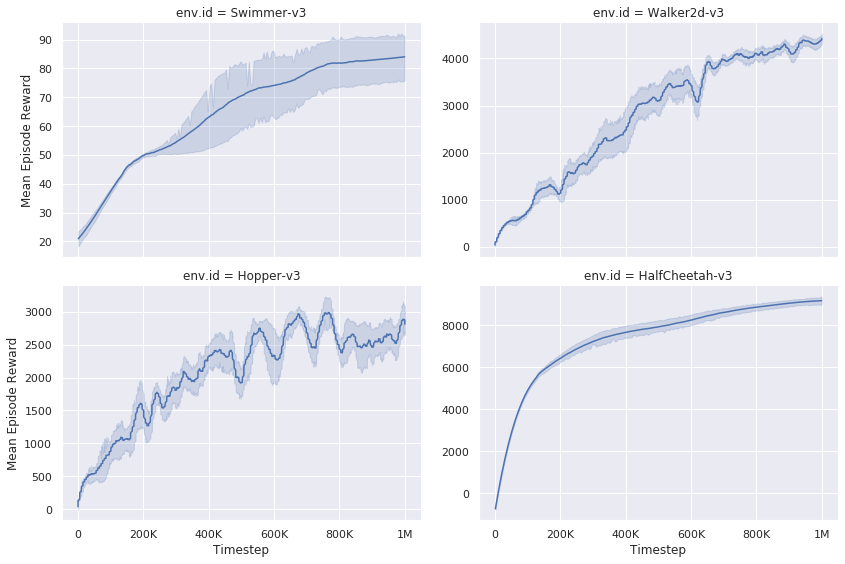

In [16]:
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue=None,
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Timestep')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [25]:
from sac.agent import Agent
from sac.experiment import make_env
ID = 0
make_video(f'{log_folder}/{ID}', make_env, Agent, seed=4153361530, num_iter=1000)

Evaluation:
	Horizon: 1000, Return: 9811.900671795667


## CEM

In [36]:
log_folder = 'cem/logs/default/'
get_configs(log_folder)

,ID,log.freq,checkpoint.num,env.standardize_obs,nn.sizes,env.clip_action,agent.std0,train.generations,train.popsize,train.mu0,train.std0,train.elite_ratio,train.noise_scheduler_args,env.id
0,0,10,3,False,"[64, 64]",True,0.6,1000,64,0.0,1.0,0.2,"[0.01, 0.001, 200, 0]",HalfCheetah-v3
1,1,10,3,False,"[64, 64]",True,0.6,1000,64,0.0,1.0,0.2,"[0.01, 0.001, 200, 0]",Hopper-v3
2,2,10,3,False,"[64, 64]",True,0.6,1000,64,0.0,1.0,0.2,"[0.01, 0.001, 200, 0]",Walker2d-v3
3,3,10,3,False,"[64, 64]",True,0.6,1000,64,0.0,1.0,0.2,"[0.01, 0.001, 200, 0]",Swimmer-v3


In [37]:
get_x = lambda log: log['generation'][0]
get_y = lambda log: log['Returns'][0].mean
file_name = 'train_logs.pkl'
data = read_xy(log_folder, file_name, get_x, get_y, smooth_out=True)
data.head()

,x,y,ID,log.freq,checkpoint.num,env.standardize_obs,nn.sizes,env.clip_action,agent.std0,train.generations,train.popsize,train.mu0,train.std0,train.elite_ratio,train.noise_scheduler_args,env.id
0,1,-9.473063,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,0.2,"(0.01, 0.001, 200, 0)",Swimmer-v3
1,2,-7.790092,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,0.2,"(0.01, 0.001, 200, 0)",Swimmer-v3
2,3,-6.125750,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,0.2,"(0.01, 0.001, 200, 0)",Swimmer-v3
3,4,-4.481028,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,0.2,"(0.01, 0.001, 200, 0)",Swimmer-v3
4,5,-2.856913,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,0.2,"(0.01, 0.001, 200, 0)",Swimmer-v3


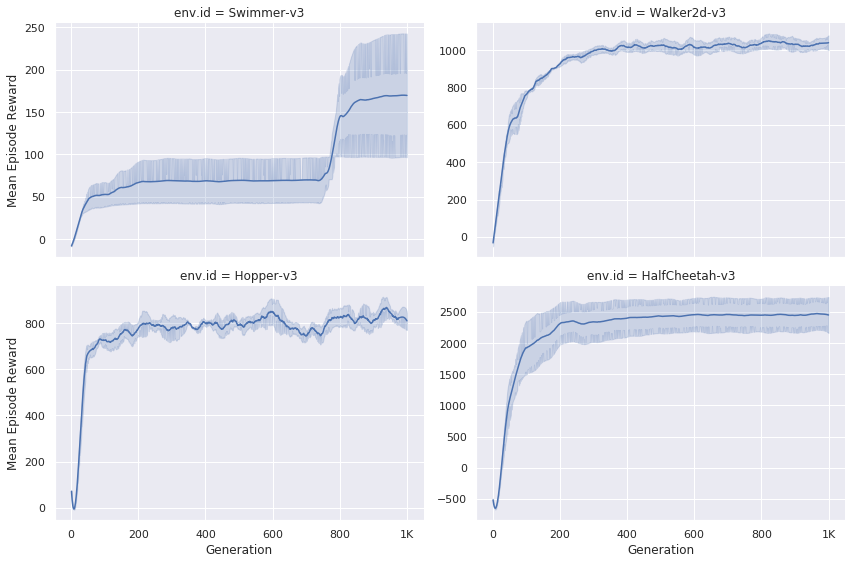

In [38]:
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue=None,
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Generation')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [39]:
from cem.agent import Agent
from cem.experiment import make_env
ID = 1
make_video(f'{log_folder}/{ID}', make_env, Agent, seed=1500925526, num_iter=1000)

Evaluation:
	Horizon: 1000, Return: 1535.601404466791


### CMA-ES

In [32]:
log_folder = 'cmaes/logs/default/'
get_configs(log_folder)

,ID,log.freq,checkpoint.num,env.standardize_obs,nn.sizes,env.clip_action,agent.std0,train.generations,train.popsize,train.mu0,train.std0,env.id
0,0,10,3,False,"[64, 64]",True,0.6,1000,64,0.0,1.0,HalfCheetah-v3
1,1,10,3,False,"[64, 64]",True,0.6,1000,64,0.0,1.0,Hopper-v3
2,2,10,3,False,"[64, 64]",True,0.6,1000,64,0.0,1.0,Walker2d-v3
3,3,10,3,False,"[64, 64]",True,0.6,1000,64,0.0,1.0,Swimmer-v3


In [33]:
get_x = lambda log: log['generation'][0]
get_y = lambda log: log['Returns'][0].mean
file_name = 'train_logs.pkl'
data = read_xy(log_folder, file_name, get_x, get_y, smooth_out=True)
data.head()

,x,y,ID,log.freq,checkpoint.num,env.standardize_obs,nn.sizes,env.clip_action,agent.std0,train.generations,train.popsize,train.mu0,train.std0,env.id
0,1,-5.466946,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,Swimmer-v3
1,2,-4.863634,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,Swimmer-v3
2,3,-4.312230,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,Swimmer-v3
3,4,-3.808929,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,Swimmer-v3
4,5,-3.349925,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,Swimmer-v3


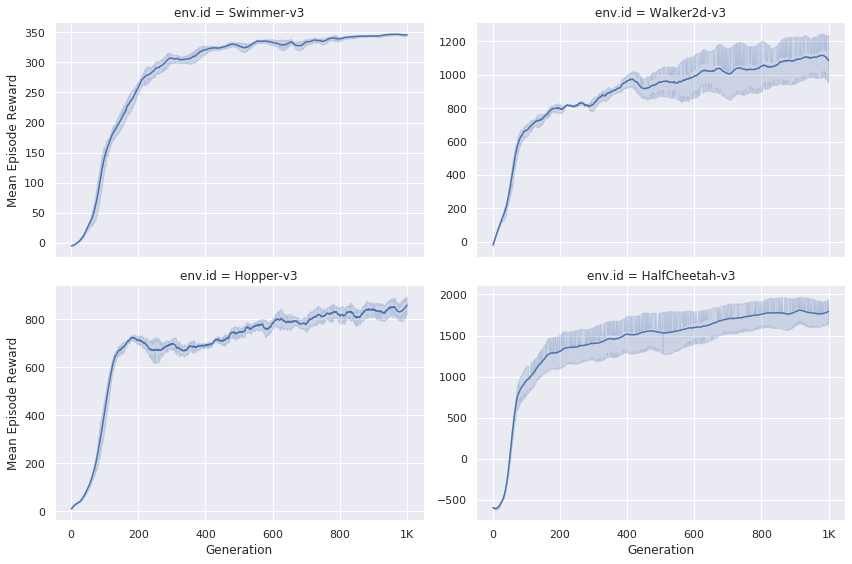

In [34]:
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue=None,
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Generation')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [35]:
from cmaes.agent import Agent
from cmaes.experiment import make_env
ID = 3
make_video(f'{log_folder}/{ID}', make_env, Agent, seed=1500925526, num_iter=1000)

Evaluation:
	Horizon: 1000, Return: 353.18763434473084


### OpenAI-ES

In [24]:
log_folder = 'openaies/logs/default/'
get_configs(log_folder)

,ID,log.freq,checkpoint.num,env.standardize_obs,nn.sizes,env.clip_action,agent.std0,train.generations,train.popsize,train.mu0,train.std0,train.lr,train.lr_decay,train.min_lr,train.sigma_scheduler_args,train.antithetic,train.rank_transform,env.id
0,0,10,3,False,"[64, 64]",True,0.6,1000,64,0.0,1.0,0.01,1.0,0.000001,"[1.0, 0.01, 450, 0]",False,True,HalfCheetah-v3
1,1,10,3,False,"[64, 64]",True,0.6,1000,64,0.0,1.0,0.01,1.0,0.000001,"[1.0, 0.01, 450, 0]",False,True,Hopper-v3
2,2,10,3,False,"[64, 64]",True,0.6,1000,64,0.0,1.0,0.01,1.0,0.000001,"[1.0, 0.01, 450, 0]",False,True,Walker2d-v3
3,3,10,3,False,"[64, 64]",True,0.6,1000,64,0.0,1.0,0.01,1.0,0.000001,"[1.0, 0.01, 450, 0]",False,True,Swimmer-v3


In [25]:
get_x = lambda log: log['generation'][0]
get_y = lambda log: log['Returns'][0].mean
file_name = 'train_logs.pkl'
data = read_xy(log_folder, file_name, get_x, get_y, smooth_out=True)
data.head()

,x,y,ID,log.freq,checkpoint.num,env.standardize_obs,nn.sizes,env.clip_action,agent.std0,train.generations,train.popsize,train.mu0,train.std0,train.lr,train.lr_decay,train.min_lr,train.sigma_scheduler_args,train.antithetic,train.rank_transform,env.id
0,1,-1.894021,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,0.01,1.0,0.000001,"(1.0, 0.01, 450, 0)",False,True,Swimmer-v3
1,2,-2.299505,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,0.01,1.0,0.000001,"(1.0, 0.01, 450, 0)",False,True,Swimmer-v3
2,3,-2.671625,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,0.01,1.0,0.000001,"(1.0, 0.01, 450, 0)",False,True,Swimmer-v3
3,4,-3.011631,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,0.01,1.0,0.000001,"(1.0, 0.01, 450, 0)",False,True,Swimmer-v3
4,5,-3.320772,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,0.01,1.0,0.000001,"(1.0, 0.01, 450, 0)",False,True,Swimmer-v3


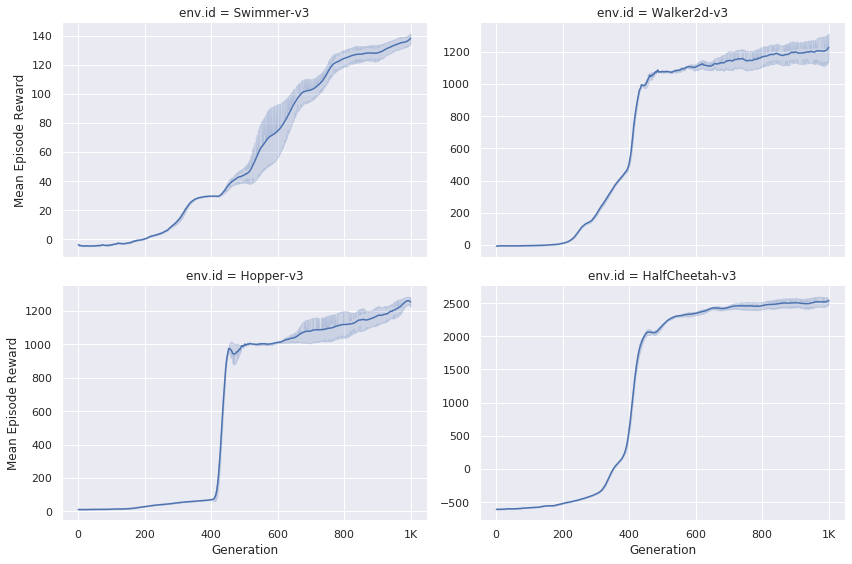

In [26]:
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue=None,
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Generation')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [27]:
from openaies.agent import Agent
from openaies.experiment import make_env
ID = 3
make_video(f'{log_folder}/{ID}', make_env, Agent, seed=1500925526, num_iter=1000)

Evaluation:
	Horizon: 1000, Return: 141.37492190674806


## Benchmarking

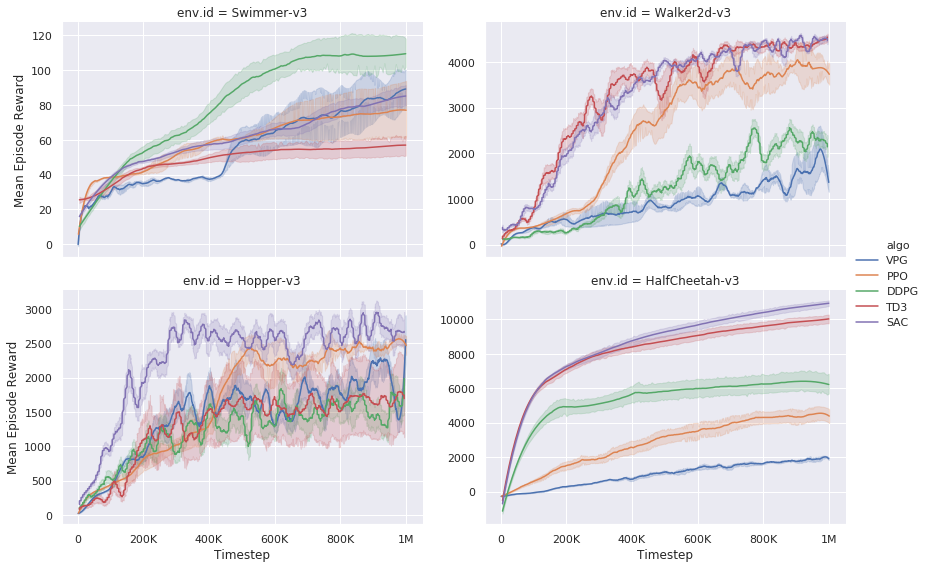

In [25]:
get_x = lambda log: log['accumulated_trained_timesteps'][0]
get_y = lambda log: log['online_return'][0].mean

data = []
d = read_xy('vpg/logs/default', 'train_logs.pkl', get_x, get_y, smooth_out=True)
d['algo'] = 'VPG'
data.append(d)
d = read_xy('ppo/logs/default', 'train_logs.pkl', get_x, get_y, smooth_out=True)
d['algo'] = 'PPO'
data.append(d)
d = read_xy('ddpg/logs/default', 'eval_logs.pkl', get_x, get_y, smooth_out=True)
d['algo'] = 'DDPG'
data.append(d)
d = read_xy('td3/logs/default', 'eval_logs.pkl', get_x, get_y, smooth_out=True)
d['algo'] = 'TD3'
data.append(d)
d = read_xy('sac/logs/default', 'eval_logs.pkl', get_x, get_y, smooth_out=True)
d['algo'] = 'SAC'
data.append(d)
data = pd.concat(data, ignore_index=True, sort=False)

err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue='algo',
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Timestep')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'benchmark_rl.png')

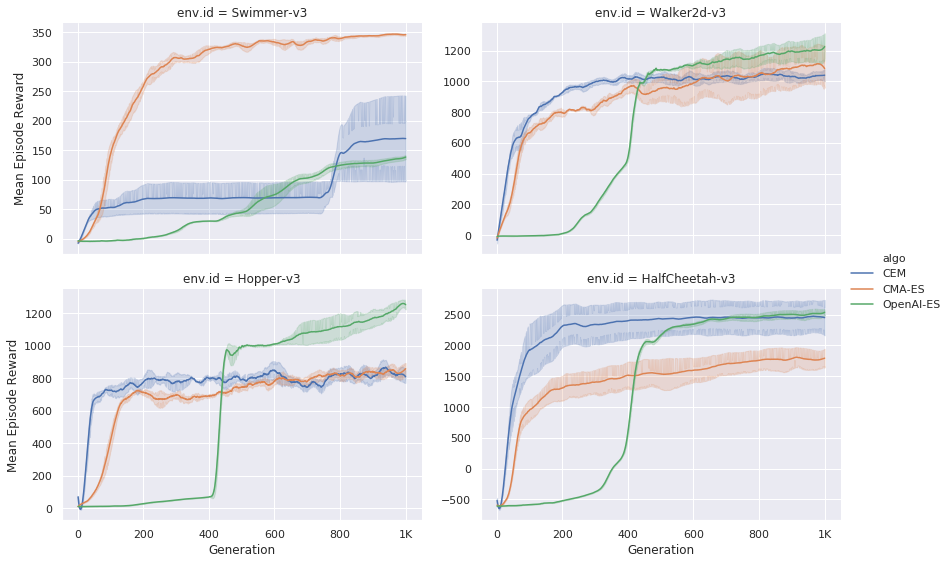

In [32]:
get_x = lambda log: log['generation'][0]
get_y = lambda log: log['Returns'][0].mean

data = []
d = read_xy('cem/logs/default', 'train_logs.pkl', get_x, get_y, smooth_out=True)
d['algo'] = 'CEM'
data.append(d)
d = read_xy('cmaes/logs/default', 'train_logs.pkl', get_x, get_y, smooth_out=True)
d['algo'] = 'CMA-ES'
data.append(d)
d = read_xy('openaies/logs/default', 'train_logs.pkl', get_x, get_y, smooth_out=True)
d['algo'] = 'OpenAI-ES'
data.append(d)
data = pd.concat(data, ignore_index=True, sort=False)

err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue='algo',
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Generation')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'benchmark_es.png')